# Illustration on synthetic data of the impact of epistemic distinction for Anomaly considering uncertainty quantification.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import math
import os
import warnings
import scipy
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Generation of synthetic data with global & local anomaly and OOD behaviour

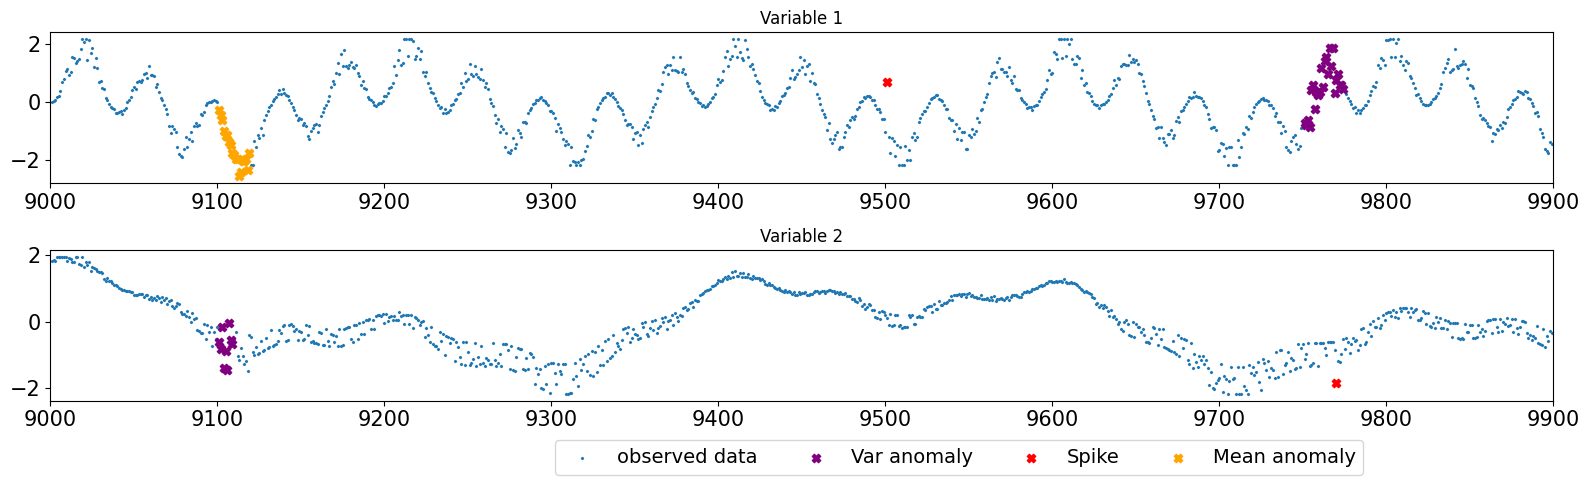

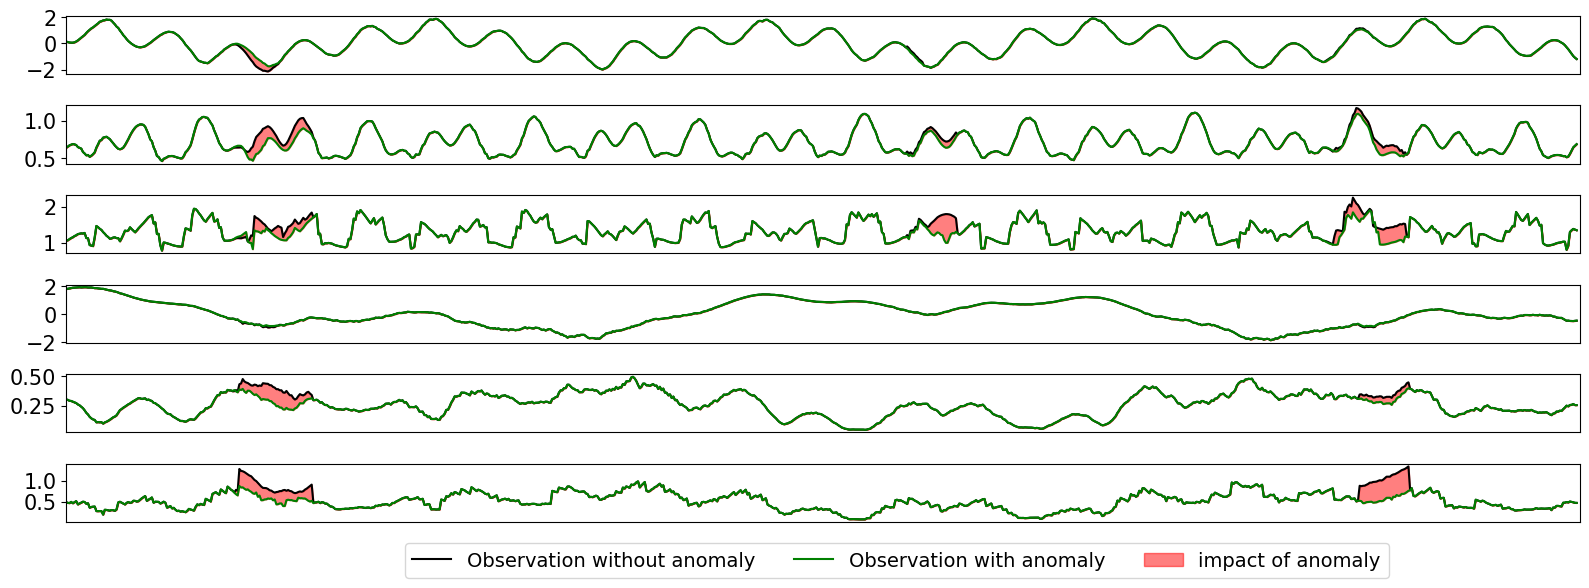

In [7]:
from uqmodels.utils import cut, base_cos_freq
%matplotlib inline
# Generation of synthetic data

X = []
y_mean = []
std =[]
X_noise = []
Y_noise = []
state = []

rng = np.random.RandomState(109)
rng = np.random.RandomState(42)

def attack_mean(y,loc,dim=[0],f=1):
    y = np.copy(y)
    len_ = len(loc)
    for d in dim:
        for t in np.arange(len_):
            y[loc[t],d] += f*np.sqrt(min(t,len_-t)/len_) 
    return(y)

def attack_var(y,loc,dim=[0],f=1):
    y = np.copy(y)
    len_ = len(loc)
    ext_min = scipy.stats.norm.ppf(0.15, 0, f*0.2)
    ext_max = scipy.stats.norm.ppf(0.85, 0, f*0.2)
    for d in dim:
        y[loc,d]+= np.maximum(np.minimum(rng.normal(0, f*0.2,len_),ext_max),ext_min)
    return(y)

def attack_spike(y,loc,dim=[0],f=1):
    y = np.copy(y)
    len_ = len(loc)
    idx = loc[int(len_/2)]
    for d in dim:
        y[idx,d]+= f
    return(y)

from uqmodels.visualization.visualization import provide_cmap
def plot_anom_matrice(
    score,
    f_obs=None,
    true_label=None,
    data=None,
    x=None,
    vmin=-3,
    vmax=3,
    cmap=None,
    list_anom_ind=None,
    figsize=(15, 6),
    grid_spec=None,
    x_date=False,
    show_plot=True,
    setup=None):
    """Plot score_anomalie matrice and true label if there is.
    Args:
        score (_type_): Anomaly score matrice or list of Anomaly matrix
        f_obs (_type_, optional): mask_focus
        true_label (_type_, optional): True label or None
        vmin (int, optional): _description_. Defaults to -3.
        vmax (int, optional): _description_. Defaults to 3.
        cmap (_type_, optional): _description_. Defaults to None.
        figsize (tuple, optional): _description_. Defaults to (15, 6).
    """
    len_score = len(score)
    dim_score = score.shape[1]

        
    n_fig=1
    sharey=True

    fig, ax = plt.subplots(
        n_fig,
        1,
        sharex=True,
        sharey=sharey,
        gridspec_kw={"height_ratios": grid_spec},
        figsize=figsize,
    )

    if n_fig == 1:
        ax.set_title("score")

        ax.imshow(
            score[f_obs].T,
            cmap=provide_cmap("bluetored"),
            vmin=vmin,
            vmax=vmax,
            aspect="auto",
            extent=None,
            interpolation="None",
        )
        ax.set_yticklabels(['0','Mean_1','Var_1','Extremum_1','Mean_2','Var_2','Extremum_2','0'],fontsize=18)
        ax.set_xticklabels(['9000','9200','9400','9600','9800'])

        if(setup) is not None:
            (n_chan,n_sensor)=setup

            for i in range(n_chan* n_sensor):
                ax.hlines(i-0.5, 0, len(f_obs), color="grey", lw=0.5)

            for i in range(n_sensor):
                ax.hlines(i * n_chan-0.5, 0, len(f_obs), color="black", lw=1)
    ax.set_xlim(0,900)
    fig.tight_layout()
    if show_plot:
        plt.show()

freq = 100
N = 10000
n_mod = 1

X = np.arange(0, freq,freq/N)
r1 = -0.31
r2 = 5.1
r3 = 1.3
r4 = 0.4
y_mean = np.cos(X*math.pi+r1) + np.cos(r2*X* math.pi)
Z_mean = np.power(np.sin(X* math.pi+r3),3) + np.cos(r4*X* math.pi)
Y_noise = cut(rng.normal(0,1.5,N),0.25,0.75) * (0.02+np.abs(y_mean)/5)
Z_noise = cut(rng.normal(0,1.2,N),0.25,0.75) * (0.02+np.abs(1-Z_mean)/5)

std = np.abs(y_mean)
state = np.zeros(len(X))

y = cut(y_mean+Y_noise,0.01,0.99)
Z = cut(Z_mean + Z_noise,0.01,0.99)

y = y.reshape(-1,1)
Z = Z.reshape(-1,1)

old_y = np.copy(y.reshape(-1,1))
old_Z = np.copy(Z.reshape(-1,1))

# Attack 1 locate on mean 1 et var 2
y = attack_mean(y,np.arange(9100,9120),f=-1.1)
Z = attack_var(Z,np.arange(9100,9120),f=2)

# Attack 1 locate on mean 1 et var 2
y = attack_spike(y,np.arange(9501,9502),f=1.55)

# Attack 4 locate on spike on Z
y = attack_var(y,np.arange(9750,9770),f=2.5)
Z = attack_spike(Z,np.arange(9770,9771),f=-0.6)

Datasets=[] # X,y,ctx,train,name
feature = X[:,None]
from sklearn.preprocessing import StandardScaler
from uqmodels.preprocessing.preprocessing import rolling_statistics

# irrealistic case :Measure on feature on un-disturbed data
mean_var_120 = rolling_statistics(pd.DataFrame(np.roll(old_y,60)),60,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values

# irrealistic Measure on feature on un-disturbed data
Z_mean_var_120 = rolling_statistics(pd.DataFrame(np.roll(old_Z,60)),60,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values


# Statistics on real disturbed observation 
mean_var_10 = rolling_statistics(pd.DataFrame(np.roll(y,0)),10,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values[:,:1]
var_and_ext = rolling_statistics(pd.DataFrame(np.roll(y,0)),30,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values[:,1:]

# Statistics on real disturbed observation 
Z_mean_var_10 = rolling_statistics(pd.DataFrame(np.roll(Z,0)),10,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values[:,:1]
Z_var_and_ext = rolling_statistics(pd.DataFrame(np.roll(Z,0)),30,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values[:,1:]

# Statistics on real un-disturbed observation : to visualisation purpose
old_mean_var_10 = rolling_statistics(pd.DataFrame(np.roll(old_y,0)),10,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values[:,:1]
old_var_and_ext = rolling_statistics(pd.DataFrame(np.roll(old_y,0)),30,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values[:,1:]

# Statistics on real un-disturbed observation : to visualisation purpose
old_Z_mean_var_10 = rolling_statistics(pd.DataFrame(np.roll(old_Z,0)),10,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values[:,:1]
old_Z_var_and_ext = rolling_statistics(pd.DataFrame(np.roll(old_Z,0)),30,1,['mean','std','extremum'],['mean','std','extremum']).replace(np.nan,0).values[:,1:]


# Contains contextual information (related to frequencies structring phenomenom + past window statistic)
features = np.concatenate([base_cos_freq(X,[0.5,2,0.5*r2,2*r2]),
                           base_cos_freq(X,[0.5,2,0.5*r4,2*r4])],axis=1)

y_no_obs = np.concatenate([y,Z],axis=1)


y = np.concatenate([mean_var_10,var_and_ext,Z_mean_var_10,Z_var_and_ext],axis=1)
y_old = np.concatenate([old_mean_var_10,old_var_and_ext,old_Z_mean_var_10,old_Z_var_and_ext],axis=1)

features = StandardScaler().fit_transform(features)
Datasets.append([features,y,state,np.arange(10000)<7000,'Unnoised ML-task'])

X,y,ctx,train,name = Datasets[0]

test = np.invert(train)

f_obs = (np.arange(len(y))>9000) & (np.arange(len(y))<9900)
plt.figure(figsize=(16,5))
plt.subplot(2,1,1)
plt.title('Variable 1')
plt.scatter(np.arange(len(X))[f_obs],y_no_obs[f_obs,0],s=2,marker="x",label='observed data')
mask_anom_1 = (np.arange(len(y))>9100) & (np.arange(len(y))<9120)
plt.scatter(np.arange(len(X))[mask_anom_1&f_obs],y_no_obs[mask_anom_1&f_obs,0],color='orange',marker='X',label='Mean anomaly')

mask_anom_1 = (np.arange(len(y))>9500) & (np.arange(len(y))<9502)
plt.scatter(np.arange(len(X))[mask_anom_1&f_obs],y_no_obs[mask_anom_1&f_obs,0],color='red',marker='X',label='Spike')

mask_anom_1 = (np.arange(len(y))>9750) & (np.arange(len(y))<9775)
plt.scatter(np.arange(len(X))[mask_anom_1&f_obs],y_no_obs[mask_anom_1&f_obs,0],color='purple',marker='X',label='Var anomaly')
plt.xlim(9000,9900)
plt.subplot(2,1,2)
plt.title('Variable 2')
plt.scatter(np.arange(len(X))[f_obs],y_no_obs[f_obs,1],s=2,marker="x",label='observed data')
mask_anom_1 = (np.arange(len(y))>9100) & (np.arange(len(y))<9110)
plt.scatter(np.arange(len(X))[mask_anom_1&f_obs],y_no_obs[mask_anom_1&f_obs,1],color='purple',marker='X',label='Var anomaly')
mask_anom_1 = (np.arange(len(y))>9769) & (np.arange(len(y))<9771)
plt.scatter(np.arange(len(X))[mask_anom_1&f_obs],y_no_obs[mask_anom_1&f_obs,1],color='red',marker='X',label='Spike')
plt.scatter(x=[],y=[],color='orange',marker='X',label='Mean anomaly')
plt.xlim(9000,9900)
plt.legend(frameon=True, ncol=6, fontsize=14, bbox_to_anchor=(0.5, 0, 0.38, -0.2))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,6))
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.plot(y[f_obs,i],color='black',label='Observation without anomaly')
    plt.plot(y_old[f_obs,i],color='green',label='Observation with anomaly')
    plt.fill_between(x=np.arange(f_obs.sum()),y1=y[f_obs,i],y2=y_old[f_obs,i],color='red',alpha=0.5,label='impact of anomaly')
    plt.xlim(0,900)
    plt.xticks([])
plt.legend(frameon=True, ncol=6, fontsize=14, bbox_to_anchor=(0.5, 0, 0.38, -0.2))
plt.tight_layout()
plt.show()

# Anomaly detection from UQModels Random forest with uncertainty quantification using residu based anomaly scores

Root mean square [array([0.09430756, 0.03809759, 0.09895293, 0.06592479, 0.02082075,
       0.05012237]), array([0.11340056, 0.04960447, 0.12806282, 0.0776516 , 0.02962544,
       0.084533  ])]
Root mean square [array([1.        , 0.99985714, 0.99957143, 1.        , 0.99971429,
       0.99857143]), array([0.99933333, 0.982     , 0.96366667, 0.99333333, 0.93833333,
       0.955     ])]
target [0.025, 0.16, 0.84, 0.975] empirique [0.0037833333333333334, 0.05188333333333333, 0.9483, 0.9945166666666667]
target elvl [0.9, 0.95, 0.99, 0.995, 0.9995, 1] empirique Elvl [0.0, 1.0, 2.0, 3.0, 5.0, 5.0]


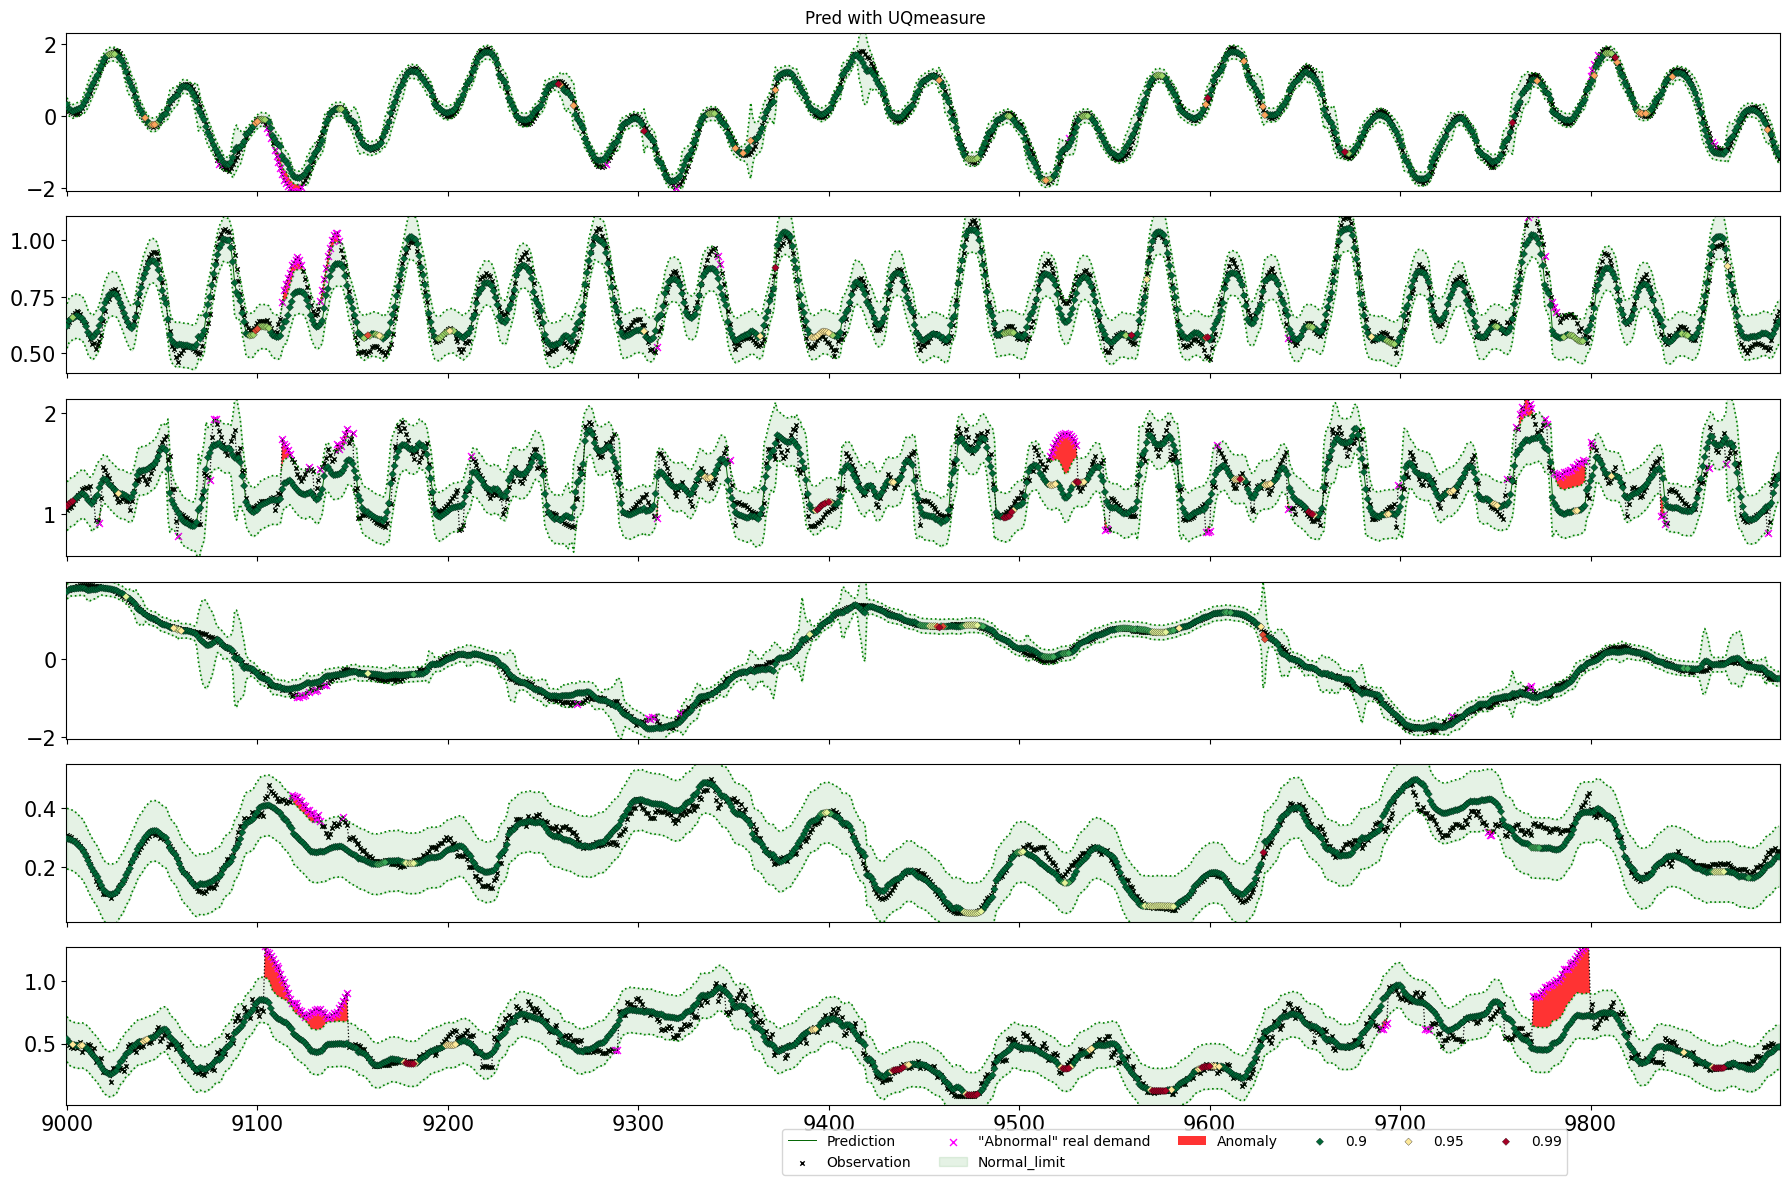

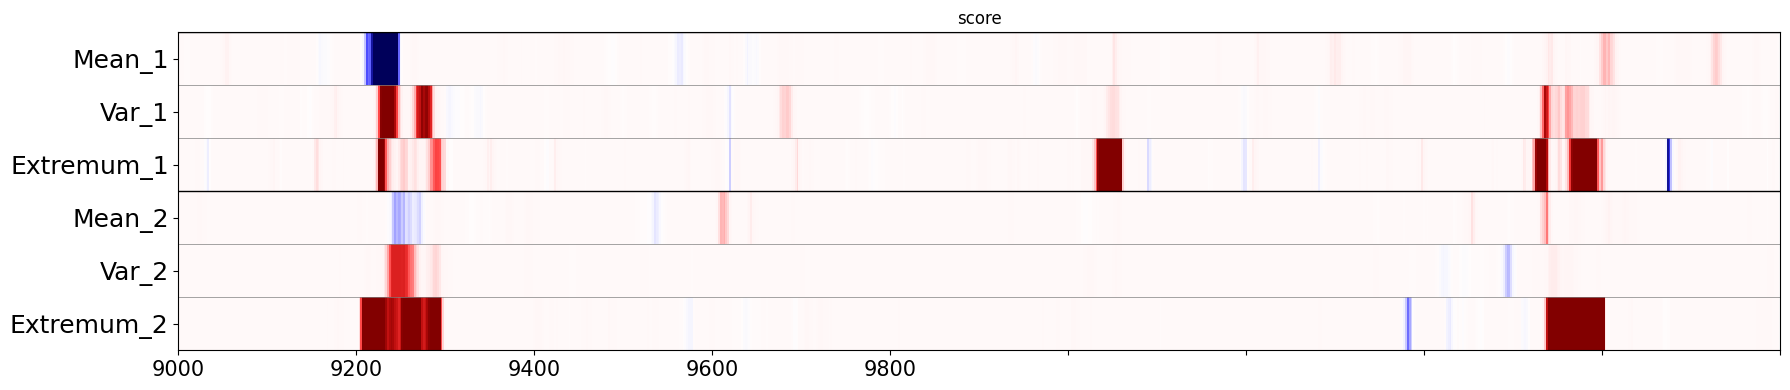

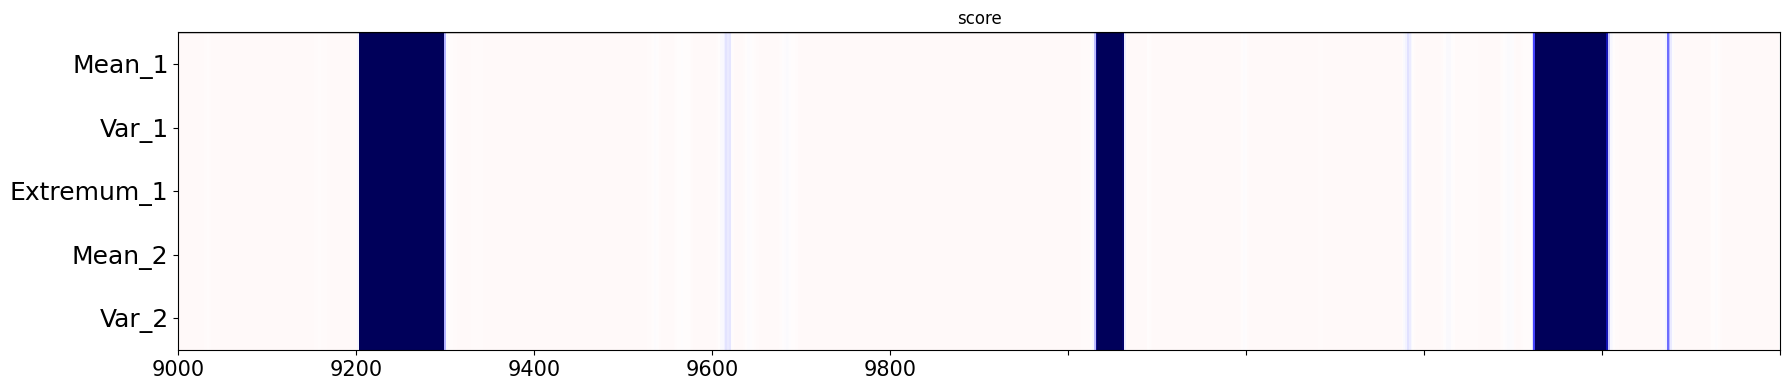

In [8]:
# Train and inference of and UQModels based on a Random forest regressor UQ-estimators


from uqmodels.modelization.ML_estimator.random_forest_UQ import RF_UQEstimator,get_params_dict
from uqmodels.custom_UQModel import UQModel_KPI,UQProc
# We can also create a more complexe UQmodel that hanUQKPI_ProcessorPI_Processor to build at inference (UQMesure, Predictive interval and model unreliability score) and after observation (Anomaly score)

# Specification of the UQestimator & Instanciation in a UQmodels wrapper that include post-processing
RF_UQ_paramaters = get_params_dict(var_min=0.000001,type_UQ='var_A&E',rescale=True,
                                   ccp_alpha=1e-06, max_depth=18, max_features=0.8,
                                   max_samples=0.8, min_impurity_decrease=0.00001,
                                   min_samples_leaf=8,min_samples_split=8, n_estimators=150,random_state=0)

RF_UQModel = UQModel_KPI(RF_UQEstimator,
                         RF_UQ_paramaters,
                         name='UQModels',
                         reduc_filter_KPI = None,
                         reduc_filter_pred= None,
                         anom_with_born=True,
                         cache_manager=None)

RF_UQModel.list_predict_KPI_processors[2].KPI_parameters = {'list_percent':[0.9, 0.95, 0.99, 0.995, 0.9995, 1]}


RF_UQModel.list_score_KPI_processors[1].KPI_parameters = {'beta': 0.0001,'type_norm':'quantiles_local','with_born': True,'d':2,'min_cut':0.05,'max_cut':0.95,
                                                          'reduc_filter': None,'q_var':2,'q_var_e':2,'k_var_e':2,'q_Eratio':3,'filt':[0.05,0.10,0.12,0.34,0.12,0.10,0.05]}

RF_UQModel.list_score_KPI_processors.append(UQProc.Anomscore_processor(KPI_parameters= {'beta': 0.0001,'type_norm':'quantiles_local','with_born': False,'d':2,'min_cut':0.05,'max_cut':0.95,
                                                                                        "fusion":True,"beta_global":0.0001,"type_fusion":"agg_sum",
                                                                                        'reduc_filter': None,'q_var':2,'q_var_e':2,'k_var_e':2,'q_Eratio':3,'filt':[0.05,0.10,0.12,0.34,0.12,0.10,0.05]}))


RF_UQModel.fit(X[train],y[train])
pred,((_,UQ),PIs,Elvl) = RF_UQModel.predict(X,y)
(pred,UQ),(KPI_anom,born_model),PIs,Escore,score_fusion = RF_UQModel.score(X,y)

from uqmodels.evaluation.metrics import Generic_metric, rmse, UQ_average_coverage, UQ_sharpness, UQ_Gaussian_NLL, UQ_dEI, UQ_absolute_residu_score
from uqmodels.evaluation.evaluation import evaluate

if(True):
    list_metrics=[Generic_metric(rmse,'Root mean square',mask=None,list_ctx_constraint=None,reduce=False,type_UQ='var_A&E'),
                  Generic_metric(UQ_average_coverage,'Root mean square',mask=None,list_ctx_constraint=None,reduce=False,type_UQ='var_A&E')]
    output = pred,UQ
    metrics_val = evaluate(y,output,list_metrics,list_sets=[train,test],verbose=True)
    
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import uqmodels.visualization.visualization as visu


list_alpha = RF_UQModel.list_predict_KPI_processors[1].KPI_parameters['list_alpha']
print('target', list_alpha, 'empirique', [(pi>y).mean() for pi in PIs])
list_percent =RF_UQModel.list_predict_KPI_processors[2].KPI_parameters['list_percent']
print('target elvl',list_percent,'empirique Elvl',[np.quantile(Elvl,q) for q in list_percent])

f_obs = np.arange(len(y))[9000:9900]
visu.uncertainty_plot(y,output,context=None,size=(18,12),f_obs=f_obs,name='Pred with UQmeasure',mode_res=False,dim=np.arange(y.shape[1]),confidence_lvl=Elvl,type_UQ='var_A&E',list_percent=list_percent,born=born_model)
plot_anom_matrice(score=KPI_anom,true_label=None,f_obs=f_obs,figsize=(18,4),vmin=-3,vmax=3,setup=(3,2))
plot_anom_matrice(score=score_fusion,true_label=None,f_obs=f_obs,figsize=(18,4),vmin=-10,vmax=10,setup=(1,1))

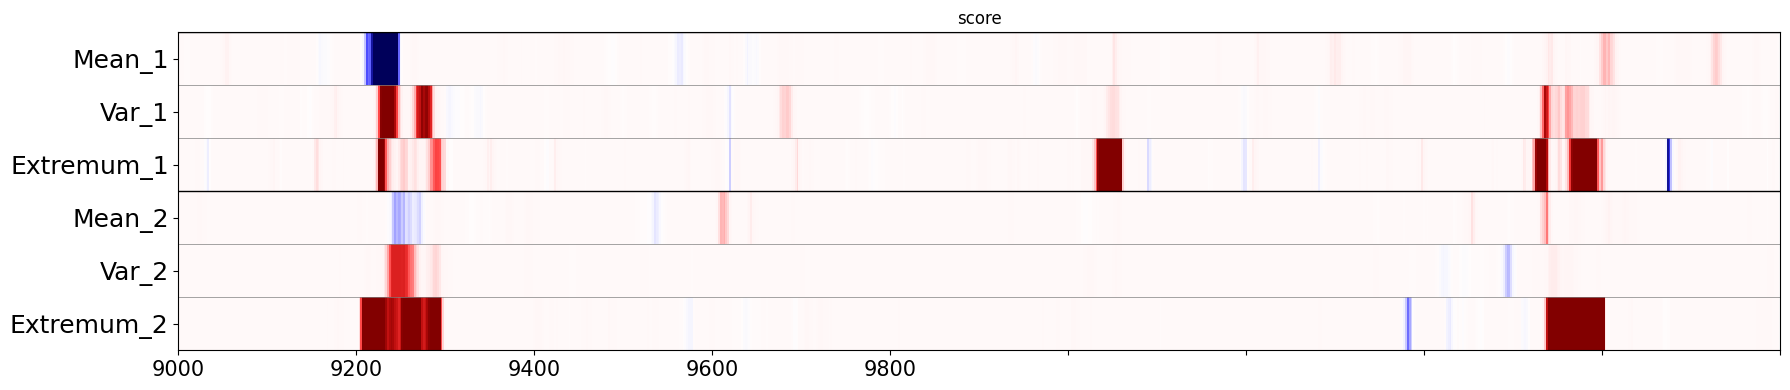

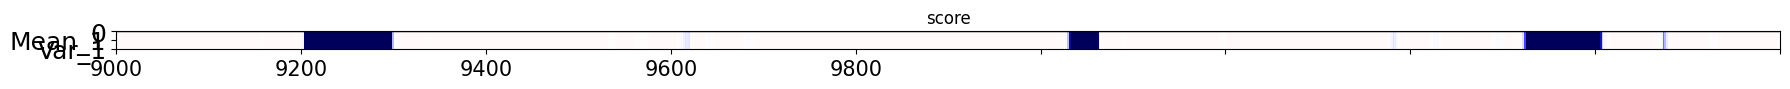

In [9]:
plot_anom_matrice(score=KPI_anom,true_label=None,f_obs=f_obs,figsize=(18,4),vmin=-3,vmax=3,setup=(3,2))
plot_anom_matrice(score=score_fusion,true_label=None,f_obs=f_obs,figsize=(18,1),vmin=-10,vmax=10,setup=(1,1))